<a href="https://colab.research.google.com/github/jhkr1/BoostCorse-AITech-Pre-Course/blob/main/Datasets_and_DataLoaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 필요한 라이브러리 가져오기

In [1]:
import os
import sys
import torch
import requests
import tarfile
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from skimage import io, transform
from torchvision import transforms, datasets
from torchvision.datasets import VisionDataset
from typing import Any, Callable, Dict, List, Optional, Tuple
from torch.utils.data import Dataset, DataLoader

## 2. Custom Dataset 복습하기

In [2]:
# 파이토치의 Dataset 클래스를 상속받아 CustomDataset 클래스를 정의한다.
class CustomDataset(Dataset):

  # 초기화 함수: 객체 생성 시 호출되며, 데이터와 레이블을 인자로 받아 저장한다.
  def __init__(self, text, labels):
    # 레이블 정보를 저장
    self.labels = labels

    # 텍스트 데이터 저장
    self.data = text

  # 데이터셋의 총 길이를 반환하는 함수
  def __len__(self):
    return len(self.labels)

  # 인덱스를 받아 해당 인덱스의 데이터와 레이블을 반환하는 함수
  def __getitem__(self, idx):

    # 해당 인덱스의 레이블 가져오기
    label = self.labels[idx]

    # 해당 인덱스의 텍스트 데이터를 가져오기
    text = self.data[idx]

    # 텍스트와 레이블을 딕셔너리 형태로 묶어반환하기
    sample = {"Text": text, "Class":label}

    return sample

In [3]:
# 텍스트 데이터와 해당 텍스트의 감정 레이블을 정의한다.
text = ['Happy', 'Amazing', 'Sad', 'Unhapy', 'Glum']
labels = ['Positive', 'Positive', 'Negative', 'Negative', 'Negative']

# CustomDataset 클래스를 사용하여 데이터셋 객체를 생성한다.
MyDataset = CustomDataset(text, labels)

In [4]:
type(MyDataset)

__main__.CustomDataset

In [7]:
# 배치 크기가 2인 DataLoader 객체를 생성하고 데이터를 섞어서 로드한다.
MyDataLoader = DataLoader(MyDataset, batch_size=2, shuffle=True)

# DataLoader에서 첫 번째 배치의 데이터를 가져와 출력한다.
next(iter(MyDataLoader))

{'Text': ['Glum', 'Amazing'], 'Class': ['Negative', 'Positive']}

In [8]:
# 배치 크기가 3인 DataLoader 객체를 생성하고, 데이터를 섞어서 로드한다.
MyDataLoader = DataLoader(MyDataset, batch_size=3, shuffle=True)

for dataset in MyDataLoader:
  print(dataset)

{'Text': ['Sad', 'Happy', 'Amazing'], 'Class': ['Negative', 'Positive', 'Positive']}
{'Text': ['Glum', 'Unhapy'], 'Class': ['Negative', 'Negative']}


## 3. NotMNIST을 이용하여 Custom Dataset 만들기

In [11]:
class NotMNIST(VisionDataset):
  # notMNIST 데이터셋의 다운로드 URL
  resource_url = 'http://yaroslavvb.com/upload/notMNIST/notMNIST_large.tar.gz'

  # 초기화 함수
  def __init__(self, root: str, train: bool = True,
               transform: Optional[Callable] = None,
               target_transform: Optional[Callable] = None,
               download: bool = False) -> None:
      # 부모 클래스(VisionDataset)의 초기화 함수를 호출
      super(NotMNIST, self).__init__(root, transform=transform, target_transform=target_transform)

      # 데이터셋이 로컬에 존재하지 않거나, download=True로 설정된 경우 다운로드를 진행
      if not self._check_exists() or download:
          self.download()

      # 데이터(이미지 경로)와 타겟(라벨)을 로드하여 인스턴스 변수에 저장
      self.data, self.targets = self._load_data()

  # 데이터셋의 길이 반환
  def __len__(self):
    return len(self.data)


  # 인덱스에 해당하는 데이터 반환
  def __getitem__(self, index):
    image_name = self.data[index]
    image = io.imread(image_name)
    label = self.targets[index]

    # 이미지에 적용할 전처리(transform)가 지정되어 있다면 실행
    if self.transform:
      image = self.transform(image)


    return image, label


  # 데이터 로드 함수
  def _load_data(self):
   # 이미지가 저장된 최상위 폴더 경로를 가져옴
    filepath = self.image_folder
    data = []
    targets = []

    # 각 클래스별로 데이터 로드
    for target in os.listdir(filepath):
      # 클래스 폴더 내의 모든 이미지 파일에 대한 전체 경로 리스트를 생성
        filenames = [os.path.abspath(os.path.join(filepath, target, x)) for x in os.listdir(os.path.join(filepath, target))]
        # 해당 클래스 라벨을 이미지 개수만큼 targets 리스트에 추가
        targets.extend([target] * len(filenames))
        data.extend(filenames)
    return data, targets

  # 원본 데이터 폴더 경로
  @property
  def raw_folder(self) -> str:
    return os.path.join(self.root, self.__class__.__name__, 'raw')

  # 압축 해제 후 이미지들이 저장된 폴더 경로를 반환하는 속성
  @property
  def image_folder(self) -> str:
    return os.path.join(self.root, 'notMNIST_large')

  # 데이터 다운로드 함수
  def download(self) -> None:
    # 원본 파일을 저장할 폴더를 생성 (폴더가 이미 있어도 에러 발생 안 함)
    os.makedirs(self.raw_folder, exist_ok=True)
    # 다운로드할 파일의 이름을 URL에서 추출
    fname = self.resource_url.split("/")[-1]
    # 차단을 피하기 위해 웹 브라우저인 것처럼 위장하는 User-Agent 정보
    user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
    # 다운로드할 파일의 전체 크기를 미리 알아옴 (진행률 표시를 위함)
    filesize = int(requests.head(self.resource_url, headers={"User-Agent": user_agent}).headers["Content-Length"])

    # requests.get으로 스트림 연결, open으로 파일 열기, tqdm으로 진행률 표시를 한번에 처리
    with requests.get(self.resource_url, stream=True, headers={"User-Agent": user_agent}) as r, \
          open(os.path.join(self.raw_folder, fname), "wb") as f, \
          tqdm(unit='B', unit_scale=True, unit_divisor=1024, total=filesize, file=sys.stdout, desc=fname) as progress:
      # 파일을 1024바이트(1KB)씩 조각(chunk)내어 다운로드
      for chunk in r.iter_content(chunk_size=1024):
        # 파일에 다운로드한 조각을 씀
        datasize = f.write(chunk)
        # 진행률 표시줄을 업데이트
        progress.update(datasize)

    # 다운로드한 파일 압축 해제
    self._extract_file(os.path.join(self.raw_folder, fname), target_path=self.root)


  # 파일 압축 해제 함수
  def _extract_file(self, fname, target_path) -> None:
    # 파일 확장자에 따라 압축 해제 방식을 결정
    tag = "r:gz" if fname.endswith("tar.gz") else "r:"
    # tarfile 라이브러리를 이용해 압축 파일을 열고
    with tarfile.open(fname, tag) as tar:
      # 지정된 경로에 압축을 해제
      tar.extractall(path=target_path)

  # 데이터셋 존재 여부 확인 함수
  def _check_exists(self) -> bool:
    return os.path.exists(self.raw_folder)



In [10]:
dataset = NotMNIST("data", download=True)

notMNIST_large.tar.gz: 100%|██████████| 236M/236M [00:08<00:00, 30.2MB/s]


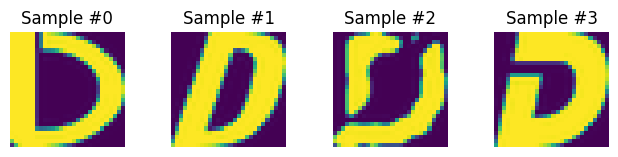

In [12]:
# 새로운 그림 (figure) 객체를 생선
fig = plt.figure()

# 8개의 샘플 이미지를 출력
for i in range(8):
  # i번째 샘플 데이터를 가져오기
  sample = dataset[i]

  # 1행 4열의 서브플롯 중 i+1번째 위치에 그래프를 그린다.
  ax = plt.subplot(1, 4, i+1)

  # 레이아웃을 조절, 그래프 간의 간격을 최적화한다.
  plt.tight_layout()

  # 서브플롯의 제목을 설정
  ax.set_title(f'Sample #{i}')

  # 서브플롯의 축을 숨긴다.
  ax.axis('off')

  # 샘플 이미지를 출력한다.
  plt.imshow(sample[0])

  # 4개의 샘플 이미지를 출력한 후 그림을 화면에 표시하고 반복문 종료
  if i == 3:
    plt.show()
    break


In [13]:
# 데이터 전처리를 위한 변환(Transform) 객체를 생성한다.
# 여러 전처리 단계를 순차적으로 적용하기 위해 Compose를 사용한다.

data_transform = transforms.Compose([
    # 224 x 224 크기 무작위로 이미지를 잘라낸다.
    transforms.RandomCrop(224),

    # 0.5의 확률로 이미지를 수평으로 뒤집는다.
    transforms.RandomHorizontalFlip(),

    # 이미지를 Tensor 형태로 변환한다.
    transforms.ToTensor(),

    # 주어진 평균과 표준편차를 사용하여 이미지를 정규화한다.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])

# NotMNIST 데이터셋을 로드, 다운로드는 X
dataset = NotMNIST("data", download=False)

In [15]:
# 데이터셋을 배치 크기로 나누어 로드하기 위한 DataLoader 객체를 생성
# 배치 크기는 128, 데이터를 섞어서 로드한다.
dataset_loader= torch.utils.data.DataLoader(dataset,
                                            batch_size=128, shuffle=True)

In [16]:
# DataLoader에서 첫 번째 배치의 특성(features)과 레이블을 가져온다
train_features, train_labels = next(iter(dataset_loader))

In [17]:
train_features.shape

torch.Size([128, 28, 28])

In [18]:
# 첫 번째 배치의 레이블을 출력한다
train_labels

('A',
 'H',
 'H',
 'I',
 'B',
 'F',
 'A',
 'E',
 'F',
 'G',
 'J',
 'B',
 'E',
 'B',
 'A',
 'H',
 'H',
 'I',
 'E',
 'G',
 'A',
 'I',
 'H',
 'H',
 'F',
 'F',
 'F',
 'D',
 'I',
 'A',
 'G',
 'J',
 'F',
 'F',
 'B',
 'B',
 'I',
 'G',
 'I',
 'D',
 'J',
 'D',
 'A',
 'B',
 'G',
 'D',
 'C',
 'H',
 'G',
 'F',
 'D',
 'D',
 'B',
 'D',
 'B',
 'F',
 'E',
 'F',
 'B',
 'D',
 'I',
 'F',
 'I',
 'F',
 'B',
 'E',
 'H',
 'J',
 'E',
 'E',
 'F',
 'F',
 'G',
 'F',
 'H',
 'J',
 'D',
 'C',
 'E',
 'C',
 'H',
 'G',
 'I',
 'I',
 'E',
 'I',
 'I',
 'A',
 'I',
 'G',
 'I',
 'I',
 'B',
 'G',
 'F',
 'J',
 'D',
 'H',
 'A',
 'C',
 'A',
 'G',
 'I',
 'E',
 'I',
 'H',
 'C',
 'E',
 'B',
 'G',
 'J',
 'J',
 'D',
 'H',
 'J',
 'F',
 'E',
 'A',
 'G',
 'C',
 'E',
 'H',
 'G',
 'H',
 'I',
 'H',
 'H',
 'H')